In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle


In [2]:
def loadDataFiles():
    market_df = pickle.load(open('Market_train',"rb"))
    news_df = pickle.load(open("News_train", "rb"))
    print('Finished loading datafiles!')
    return market_df, news_df


In [3]:
def preprocess_data(mkt_df, news_df):
    mkt_df['time'] = pd.to_datetime(mkt_df['time'])
    news_df['time'] = pd.to_datetime(news_df['time'])
    mkt_df['time'] = mkt_df['time'].dt.date
    news_df['time'] = news_df['time'].dt.date
    assetCodes = []
    index = 0
    for x in news_df['assetCodes']:
        x = x.split(',')[0].split("'")[1]
        assetCodes.append(x)
    news_df['assetCode'] = np.asarray(assetCodes)
    irrelevantColumns = ['sourceTimestamp', 'firstCreated', 'sourceId', 
                         'headline', 'provider', 'subjects', 'audiences',
                        'headlineTag', 'marketCommentary', 'assetCodes', 'assetName']
    news_df.drop(irrelevantColumns, axis=1, inplace=True)
    mkt_df.drop(['assetName'], axis=1, inplace=True)
    modifiednews = news_df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    # join news reports to market data, note many assets will have many days without news data
    merged = pd.merge(mkt_df, modifiednews, how='left', on=['time', 'assetCode'], copy=False) 
    merged = merged.fillna(0)
    print('Finished preprocessing data!')
    return merged


In [4]:
market_data, news_data = loadDataFiles()


Finished loading datafiles!


In [5]:
X = preprocess_data(market_data, news_data)


Finished preprocessing data!


In [6]:
def normalizeY(ydf):
    ydf = (ydf + 1) / 2
    return ydf


In [8]:
X = X[X['returnsOpenNextMktres10'] >= -1]
X = X[X['returnsOpenNextMktres10'] <= 1]

y = X['returnsOpenNextMktres10']

X.drop(['returnsOpenNextMktres10'], axis=1, inplace=True)
y = normalizeY(y)
assetCodesAndTime = X.iloc[:, :2]
X = X.iloc[:, 2:]


In [9]:
def getNNModel(numhiddenlayers=2, nodes=4): # returns NN given hidden layers and nodes
    layers = []
    layers.append(keras.layers.Flatten(input_shape=(35,)))

    for x in range(numhiddenlayers):
        layers.append(keras.layers.Dense(nodes, activation=tf.nn.relu, use_bias=True))

    layers.append(keras.layers.Dense(1, activation=tf.nn.sigmoid))
    model = keras.Sequential(layers)
    sgd = keras.optimizers.SGD(lr=.3)
    model.compile(optimizer=sgd,
              loss='mean_absolute_error',
              metrics=['accuracy'])
    return model


In [10]:
def getLinearRegressionModel():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=200, input_dim=35))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(units=45))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mean_absolute_error',
              optimizer='sgd')
    return model


In [11]:
def regularize(df):
    for column in df:
        colmin = np.amin(df[column])
        colmax = np.amax(df[column])
        df[column] = (df[column] - colmin) / (colmax - colmin)
    return df

In [12]:
X = regularize(X)

In [14]:
nnmodel = getNNModel(3, 15)
nnmodel.fit(X, y, epochs=1, verbose=1, batch_size=100000, validation_split=.7)
# results = nnmodel.evaluate(X_test, y_test)
# print(results)

4072203
Epoch 1/1
1221661/1221661 [==============================] - 15s 12us/step
[0.021965545483945612, 0.0]


In [15]:
def lossMatrix(layers, nodes):
    lossmatrix = []
    for layer in layers:
        lossforlayer = []
        for node in nodes:
            nnmodel2 = getNNModel(layer, node)
            nnmodel2.fit(X,y, epochs=1, verbose=1, batch_size=1000000)
            loss, acc = nnmodel2.evaluate(X, y)
            lossforlayer.append(loss)
        lossmatrix.append(lossforlayer)
    print(lossmatrix)

In [16]:
lrmodel = getLinearRegressionModel()
lrmodel.fit(X,y, batch_size=1000000, epochs=1, validation_split=.7)
lrpredictions = lrmodel.predict(X_test)
loss = lrmodel.evaluate(X_test,y_test)
print(loss)

Epoch 1/1
1221661/1221661 [==============================] - 15s 12us/step
0.4631840726926496


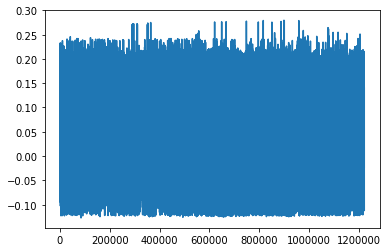

In [17]:
xplot = list(range(len(y_test)))
plt.plot(xplot, lrpredictions)
plt.show()

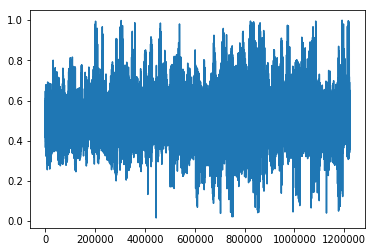

In [18]:
plt.plot(xplot, y_test)
plt.show()

In [24]:
newnnmodel = getNNModel(3,15)
hist = keras.callbacks.History()
num_epochs = 10
newnnmodel.fit(X, y, epochs=num_epochs, batch_size=1000000, callbacks=[hist], validation_split=.3)

Train on 2850542 samples, validate on 1221661 samples
Epoch 1/10
2850542/2850542 [==============================] - 7s 2us/step - loss: 0.0358 - acc: 0.0000e+00 - val_loss: 0.0237 - val_acc: 0.0000e+00
Epoch 2/10
2850542/2850542 [==============================] - 6s 2us/step - loss: 0.0250 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 3/10
2850542/2850542 [==============================] - 6s 2us/step - loss: 0.0244 - acc: 0.0000e+00 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 4/10
2850542/2850542 [==============================] - 6s 2us/step - loss: 0.0241 - acc: 0.0000e+00 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 5/10
2850542/2850542 [==============================] - 6s 2us/step - loss: 0.0240 - acc: 0.0000e+00 - val_loss: 0.0221 - val_acc: 0.0000e+00
Epoch 6/10
2850542/2850542 [==============================] - 6s 2us/step - loss: 0.0239 - acc: 0.0000e+00 - val_loss: 0.0220 - val_acc: 0.0000e+00
Epoch 7/10
2850542/2850542 [==============================

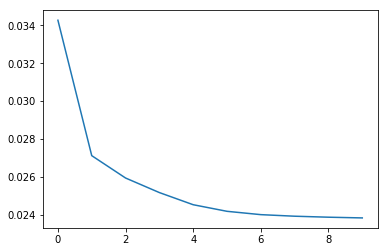

In [20]:
xr = list(range(num_epochs))
plt.plot(xr, hist.history['loss'])
plt.show()

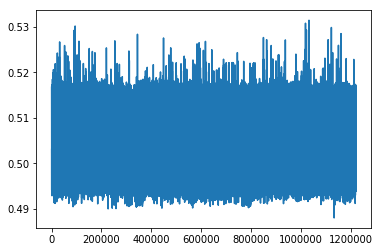

In [21]:
newnnpredictions = newnnmodel.predict(X_test)
ss = list(range(len(X_test)))
plt.plot(ss, newnnpredictions)
plt.show()

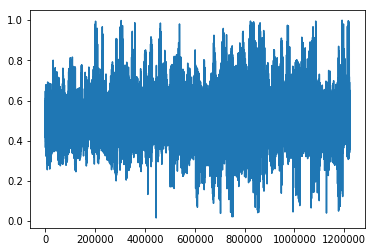

In [22]:
plt.plot(ss, y_test)
plt.show()